# Mejorar circunferencia ajustada
* Investigación en pregrado Departamento de ingeniería mecánica - Pontificia Universidad Católica de Chile.
* Docente a cargo: David Acuña.
* Alumno: Sebastián Villagra.
* Fecha: Abril 2024.

### Importar librerías y leer archivos
Se trabaja con numpy, pandas y matplotlib. Se toman 6 EIS para el estado I.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df1_C1 = pd.read_csv("EIS_state_I_25C01.csv",sep=',', header=0, index_col=False)
df1_C1.head(5)

df_C2 = pd.read_csv("EIS_state_I_25C02.csv",sep=',', header=0, index_col=False)
df_C3 = pd.read_csv("EIS_state_I_25C03.csv",sep=',', header=0, index_col=False)
df_C4 = pd.read_csv("EIS_state_I_25C04.csv",sep=',', header=0, index_col=False)
df_C5 = pd.read_csv("EIS_state_I_25C05.csv",sep=',', header=0, index_col=False)
df_C6 = pd.read_csv("EIS_state_I_25C06.csv",sep=',', header=0, index_col=False)

In [7]:
df1_C1.shape[0]/60

350.0

### Definición de funciones a utilizar
Se definen 2 funciones que permiten extraer las lecturas de resistencia  reactancia para un único ciclo de un archivo txt.

In [11]:
# Funciones para extraer resistencias (R) y reactancias (X).

def cycle_resistances(dataFrame):
    # Input: Txt de la base de datos de EIS Cambridge como DataFrame
    # Output: Lista con 350 listas. Cada una son los valores de resistencia
    #         de un mismo ciclo

    resistance_arrays = []
    Ns = int(dataFrame.shape[0]/60)
    for i in range(1,Ns+1):
        df1 = dataFrame[dataFrame["cycle number"]==i].copy(deep=True)
        reZ = df1["Re(Z)/Ohm"].to_list()
        resistance_arrays.append(reZ)
    return resistance_arrays

def cycle_reactances(dataFrame):
    # Input: Txt de la base de datos de EIS Cambridge como DataFrame
    # Output: Lista con 350 listas. Cada una son los valores de reactancia
    #         de un mismo ciclo
    reactance_arrays = []
    Ns = int(dataFrame.shape[0]/60)
    for i in range(1,Ns+1):
        df1 = dataFrame[dataFrame["cycle number"]==i].copy(deep=True)
        imZ = df1["-Im(Z)/Ohm"].to_list()
        reactance_arrays.append(imZ)
    return reactance_arrays

### Separación de data
Con las funciones anteriores se extraen R y X para cada Data Frame.

In [28]:
# Data Bateria 1
resistencias_C1 = cycle_resistances(df1_C1)
reactancias_C1 = cycle_reactances(df1_C1)
# Data Bateria 2
resistencias_C2 = cycle_resistances(df_C2)
reactancias_C2 = cycle_reactances(df_C2)
# Data Bateria 3
resistencias_C3 = cycle_resistances(df_C3)
reactancias_C3 = cycle_reactances(df_C3)
# Data Bateria4
resistencias_C4 = cycle_resistances(df_C4)
reactancias_C4 = cycle_reactances(df_C4)
# Dataa Bateria 5
resistencias_C5 = cycle_resistances(df_C5)
reactancias_C5 = cycle_reactances(df_C5)
# Data Bateria 6
resistencias_C6 = cycle_resistances(df_C6)
reactancias_C6 = cycle_reactances(df_C6)

### Gráficos generales
Se grafican diagramas de Nyquist: parte real versus parte imaginaria de la impedancia para un único EIS.

Text(0.5, 0, 'Re (Z)')

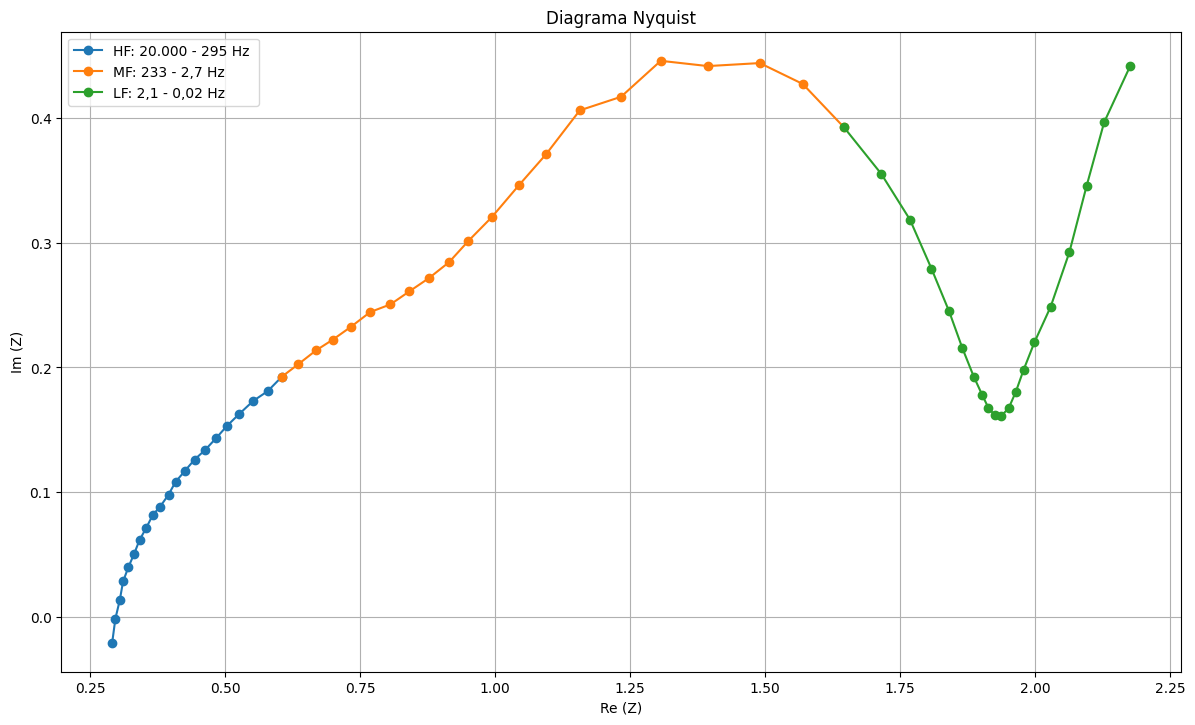

In [5]:
fig1 = plt.figure(figsize=(14,8))
ax = plt.axes([0.1, 0.1, 0.8, 0.8])
ax.plot(resistencias_C4[81][0:20+1],reactancias_C4[81][0:20+1], marker='o', label="HF: 20.000 - 295 Hz ")
ax.plot(resistencias_C4[81][21-1:40+1],reactancias_C4[81][21-1:40+1], marker='o', label="MF: 233 - 2,7 Hz ")
ax.plot(resistencias_C4[81][41-1:60],reactancias_C4[81][41-1:60], marker='o', label="LF: 2,1 - 0,02 Hz ")
ax.legend()
ax.grid()
ax.set_title("Diagrama Nyquist - S1 - C4 - Ciclo 82")
ax.set_ylabel("Im (Z)")
ax.set_xlabel("Re (Z)")

Text(0.5, 0, 'Re (Z)')

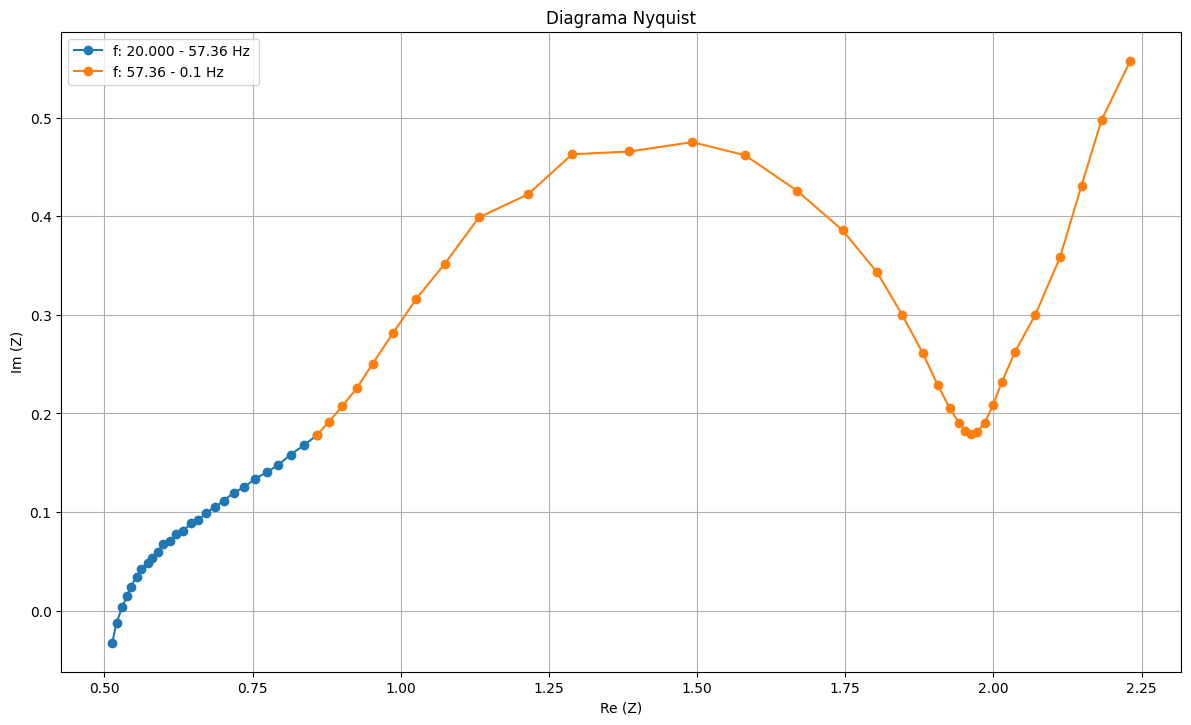

In [32]:
fig2 = plt.figure(figsize=(14,8))
ax2 = plt.axes([0.1, 0.1, 0.8, 0.8])
ax2.plot(resistencias_C1[292][0:25+2],reactancias_C1[292][0:25+2], marker='o', label="f: 20.000 - 57.36 Hz ")
ax2.plot(resistencias_C1[292][25+1:60+1],reactancias_C1[292][25+1:60+1], marker='o', label="f: 57.36 - 0.1 Hz")
ax2.legend()
ax2.grid()
ax2.set_title("Diagrama Nyquist - S1 - C1 - Ciclo 293")
ax2.set_ylabel("Im (Z)")
ax2.set_xlabel("Re (Z)")

# Propuesta algoritmo
* Sobre cierta frecuencia - 233.8 Hz.
* Pendiente estancada.
* PROMEDIO Derivada menor a 0.45 -> guardar índice i.
* Se calcula la segunda derivada y se calcula el promedio de i junto a las siguientes 3 muestras.
* Si el promedio es mayor a cero: cortar ahí.

## Algoritmo

**1. Cálculo de pendiente**

Se imprimen las pendientes discretas entre cada punto.  $m_{i+1} = \frac {x_{i+1} - x_i}{r_{i+1} - r_i}$. Este valor $m$ se imprime en la coordenada final, es decir en el par coordenado $(r_{i+1}, x_{i+1})$. De esta forma, se itera desde $i=0$ hasta $i=N_s-1$ con $N_s$ el número de muestras.  

Con esto se plotea el diagrama de Nyquist desde los 20 kHz hasta los 57.4 Hz con los que se ajusta la circunferencia originalmente.

In [37]:
# Buscar posicion en que la frecuencia del EIS es de 57.4 Hz
for i in range(0,60):   # Iterar en todas las muestras de un ciclo
    if (df_C4["freq/Hz"].iloc[i] < 60):     # Buscar cuando la entrada "freq" es menor a 60 Hz
        pos = i
        break       # Se rompe el loop y se almacena la posicion actual
print(i)

25


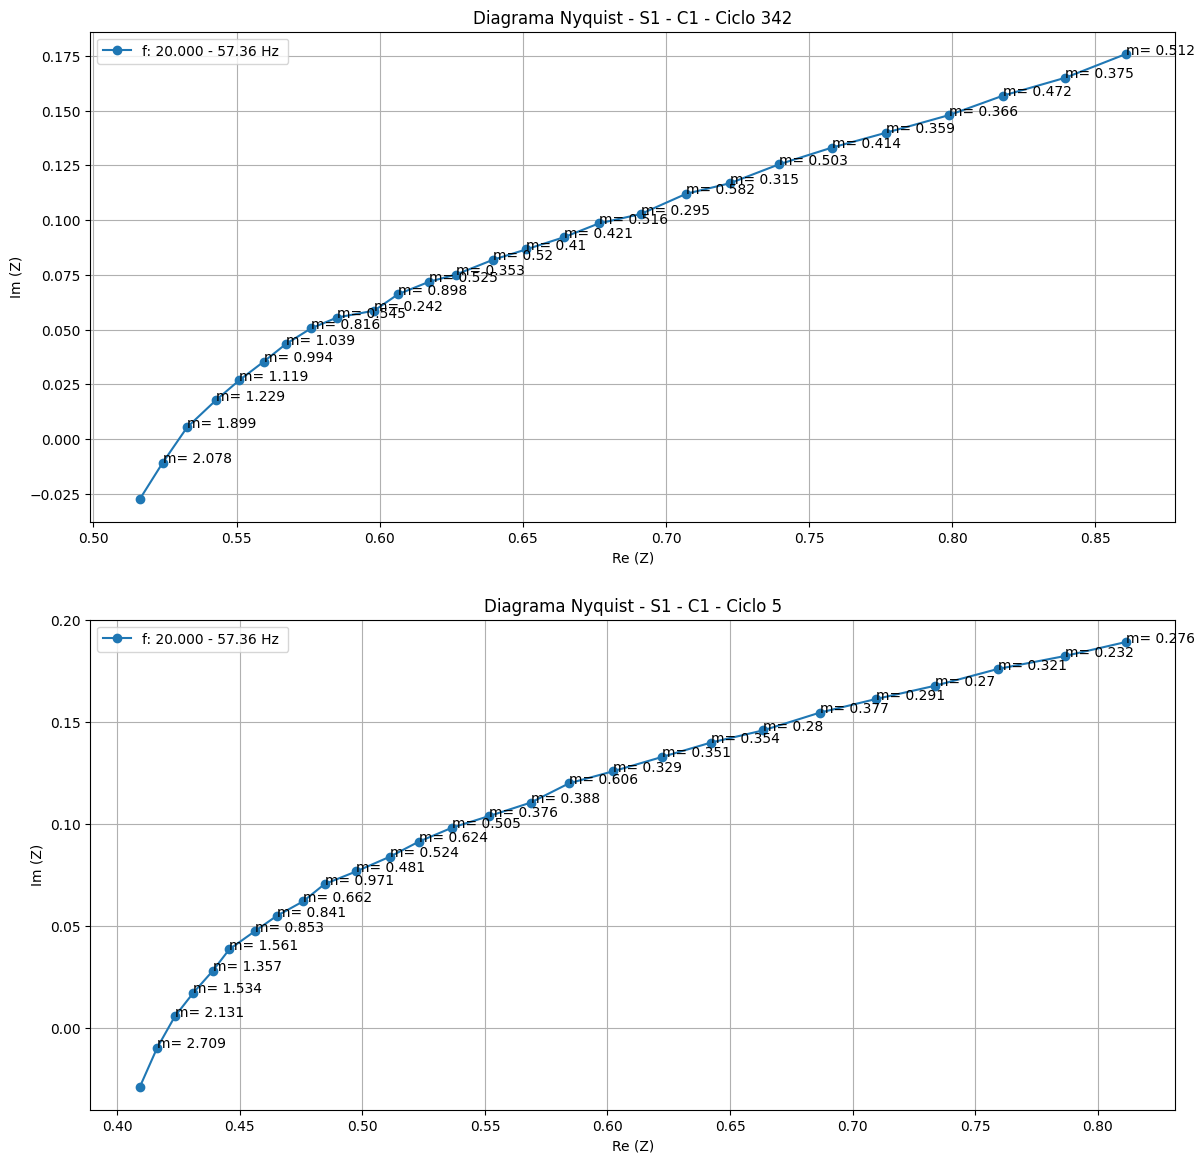

In [71]:
x = reactancias_C1[341]
r = resistencias_C1[341]

xn = reactancias_C1[4]
rn = resistencias_C1[4]

# sample [25] es la frecuencia 57.4 Hz
fig3, ax3 = plt.subplots(nrows=2, ncols=1, figsize=(14,14))

ax3[0].plot(r[0:25+2],x[0:25+2], marker='o', label="f: 20.000 - 57.36 Hz ")
#ax3.plot(r[25+1:42],x[25+1:42], marker='o', label="f: 57.36 - 0.1 Hz")
ax3[0].legend()
ax3[0].grid()
ax3[0].set_title("Diagrama Nyquist - S1 - C1 - Ciclo 342")
ax3[0].set_ylabel("Im (Z)")
ax3[0].set_xlabel("Re (Z)")
for i in range(0,27-1):
    m = (x[i+1]-x[i])/(r[i+1]-r[i]) # calcular derivada
    ax3[0].annotate("m= "+str(round(m,3)), xy=(r[i+1],x[i+1]))

ax3[1].plot(rn[0:25+2],xn[0:25+2], marker='o', label="f: 20.000 - 57.36 Hz ")
#ax3.plot(r[25+1:42],x[25+1:42], marker='o', label="f: 57.36 - 0.1 Hz")
ax3[1].legend()
ax3[1].grid()
ax3[1].set_title("Diagrama Nyquist - S1 - C1 - Ciclo 5")
ax3[1].set_ylabel("Im (Z)")
ax3[1].set_xlabel("Re (Z)")
for i in range(0,27-1):
    m = (xn[i+1]-xn[i])/(rn[i+1]-rn[i]) # calcular derivada
    ax3[1].annotate("m= "+str(round(m,3)), xy=(rn[i+1],xn[i+1]))

### Cálculo de la 2da derivada
Se repite el procedimiento anterior. Se toma la derivada en $i+1$ y en $i+2$. Luego esta es la segunda derivada en $i+2$.

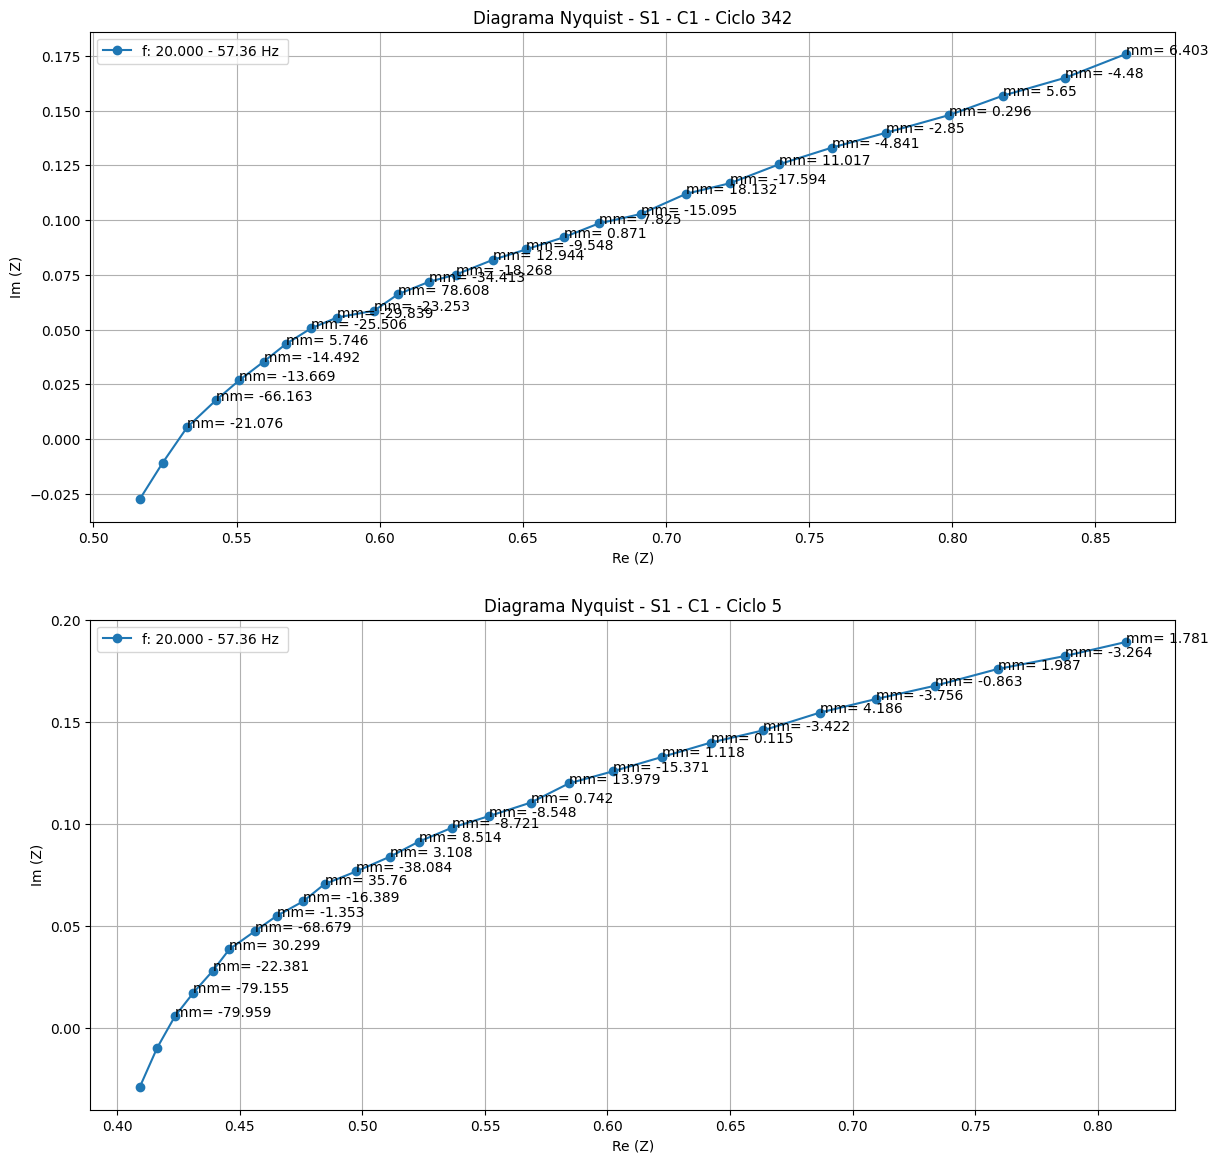

In [83]:
fig4, ax4 = plt.subplots(nrows=2, ncols=1, figsize=(14,14))

ax4[0].plot(r[0:25+2],x[0:25+2], marker='o', label="f: 20.000 - 57.36 Hz ")
#ax3.plot(r[25+1:42],x[25+1:42], marker='o', label="f: 57.36 - 0.1 Hz")
ax4[0].legend()
ax4[0].grid()
ax4[0].set_title("Diagrama Nyquist - S1 - C1 - Ciclo 342")
ax4[0].set_ylabel("Im (Z)")
ax4[0].set_xlabel("Re (Z)")
for i in range(0,27-2):
    m0 = (x[i+1]-x[i])/(r[i+1]-r[i]) # calcular derivada
    m1 = (x[i+2]-x[i+1])/(r[i+2]-r[i+1])
    mm = (m1-m0)/(r[i+2]-r[i+1])
    ax4[0].annotate("mm= "+str(round(mm,3)), xy=(r[i+2],x[i+2]))

ax4[1].plot(rn[0:25+2],xn[0:25+2], marker='o', label="f: 20.000 - 57.36 Hz ")
#ax3.plot(r[25+1:42],x[25+1:42], marker='o', label="f: 57.36 - 0.1 Hz")
ax4[1].legend()
ax4[1].grid()
ax4[1].set_title("Diagrama Nyquist - S1 - C1 - Ciclo 5")
ax4[1].set_ylabel("Im (Z)")
ax4[1].set_xlabel("Re (Z)")
for i in range(0,27-2):
    m0 = (xn[i+1]-xn[i])/(rn[i+1]-rn[i]) # calcular derivada
    m1 = (xn[i+2]-xn[i+1])/(rn[i+2]-rn[i+1])
    mm = (m1-m0)/(rn[i+2]-rn[i+1])
    ax4[1].annotate("mm= "+str(round(mm,3)), xy=(rn[i+2],xn[i+2]))

In [16]:
def derivada_imZ(r,x):
    d = [0] 
    for i in range(len(x)-1):
        m1 = (x[i+1]-x[i])/(r[i+1]-r[i])    # dx/dr en i+1
        d.append(m1)
    return d

def derivada2_imZ(r,x):
    d2 = [0,0]
    for i in range(len(x)-2):
        m1 = (x[i+1]-x[i])/(r[i+1]-r[i])    # dx/dr en i+1
        m2 = (x[i+2]-x[i+1])/(r[i+2]-r[i+1])    # dx/dr en i+2
        mm2 = (m2-m1)/(r[i+2]-r[i+1])    # d2x/dr2 en i+2
        d2.append(mm2)
    return d2

def avgs_d1(d1x):
    d1s_avg = [0,0]
    for i in range(len(d1x)-3-2):
        avg = (d1x[i+2] + d1x[i+3] + d1x[i+4] + d1x[i+5])*0.25  # promedio 4 muestras
        d1s_avg.append(avg)
    return d1s_avg

def search_curve(r,x):
    c1 = 0                  # condicion 1
    c2 = 0                  # condicion 2
    j = 25                  # default: cortat a los 57.4 Hz
    d1 = derivada_imZ(r,x)  # Primeras derivadas
    d2 = derivada2_imZ(r,x) # Segundas derivadas
    mean4_d1 = avgs_d1(d1)  # Promedios 4 samples d1
    mean4_d2 = avgs_d1(d2)  # Promedios 4 samples d2
    # A buscar el indice
    # 1.- Buscar el indice en que el avg d1 es menor a 0.45 -> linea diagonal
    for i in range(2,30):
        if (mean4_d1[i] < 0.45):
            j = i
            c1 = 1
            break
    # 2.- A partir del indice anterior, buscar cuando avg d2 es mayor a 0 -> curva hacia arriba
    if (c1 == 1):
        for i in range(j,30):
            if (mean4_d2[i] > 0):
                j = i
                c2 = 1
                break
    return j

In [17]:
search_curve(rn,xn)

NameError: name 'rn' is not defined

## Estado V

In [12]:
df_C2_S5 = pd.read_csv("EIS_state_V_25C02.csv",sep=',', header=0, index_col=False)
r_state5 = cycle_resistances(df_C2_S5)
x_state5 = cycle_reactances(df_C2_S5)

In [18]:
search_curve(r_state5[9], x_state5[9])

19

Text(0.5, 0, 'Re (Z)')

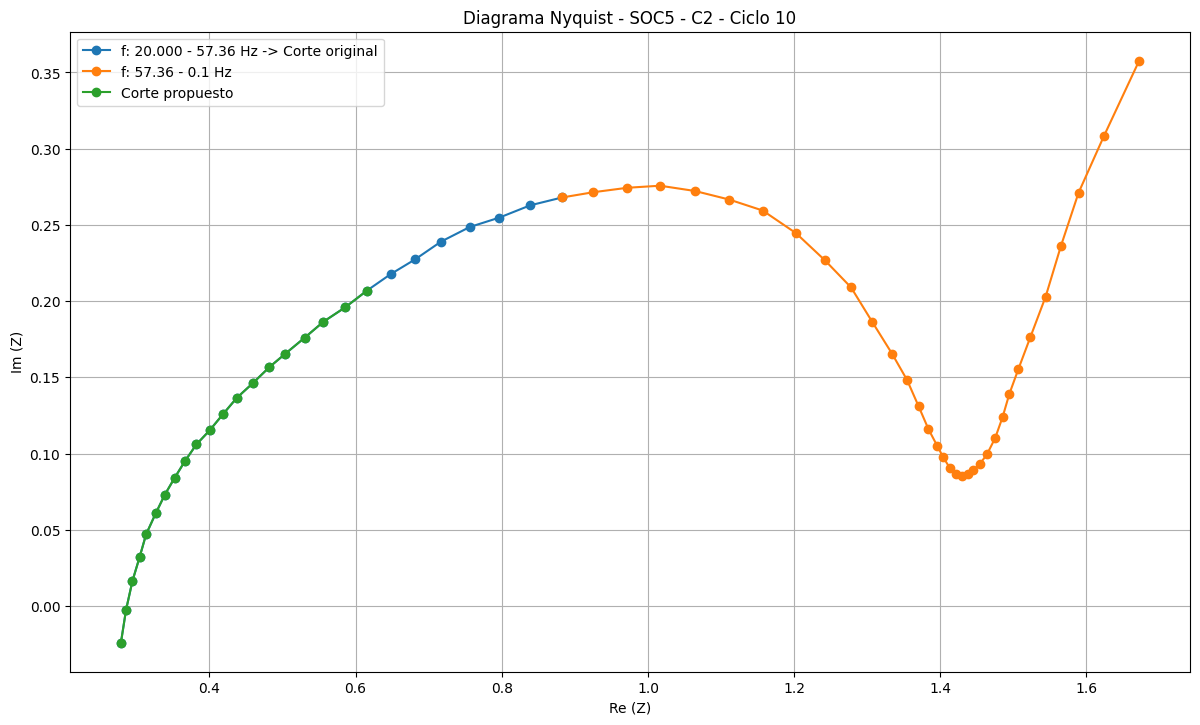

In [21]:
fig5 = plt.figure(figsize=(14,8))
ax5 = plt.axes([0.1, 0.1, 0.8, 0.8])
ax5.plot(r_state5[9][0:25+2],x_state5[9][0:25+2], marker='o', label="f: 20.000 - 57.36 Hz -> Corte original")
ax5.plot(r_state5[9][25+1:60+1],x_state5[9][25+1:60+1], marker='o', label="f: 57.36 - 0.1 Hz")
ax5.plot(r_state5[9][0:20],x_state5[9][0:20], marker='o', label="Corte propuesto")
ax5.legend()
ax5.grid()
ax5.set_title("Diagrama Nyquist - SOC5 - C2 - Ciclo 10")
ax5.set_ylabel("Im (Z)")
ax5.set_xlabel("Re (Z)")

In [23]:
search_curve(r_state5[199],x_state5[199])

17

Text(0.5, 0, 'Re (Z)')

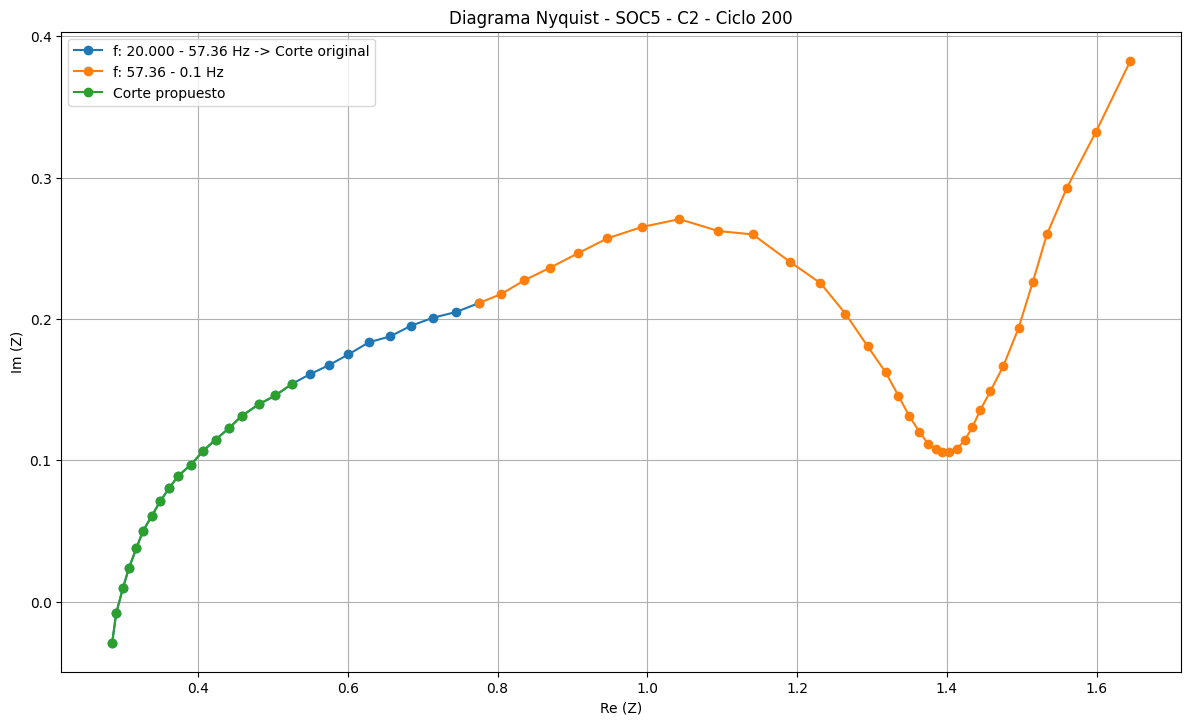

In [24]:
fig6 = plt.figure(figsize=(14,8))
ax6 = plt.axes([0.1, 0.1, 0.8, 0.8])
ax6.plot(r_state5[199][0:25+2],x_state5[199][0:25+2], marker='o', label="f: 20.000 - 57.36 Hz -> Corte original")
ax6.plot(r_state5[199][25+1:60+1],x_state5[199][25+1:60+1], marker='o', label="f: 57.36 - 0.1 Hz")
ax6.plot(r_state5[199][0:18],x_state5[199][0:18], marker='o', label="Corte propuesto")
ax6.legend()
ax6.grid()
ax6.set_title("Diagrama Nyquist - SOC5 - C2 - Ciclo 200")
ax6.set_ylabel("Im (Z)")
ax6.set_xlabel("Re (Z)")